<h1 align="center">PART A: CLASSIFICATION</h1><br>
<center><u><h2><b>Objective: Develop a classification model to predict default payment.</b></h2></u><br><br></center>
<b>Customer ID:</b> A unique identifier for each customer.<br><br>
<b>Credit Limit:</b> The maximum amount of credit that each customer is allowed to borrow.<br><br>
<b>Gender:</b> The gender of the customer.<br><br>
<b>Education:</b> The educational background of the customer.<br><br>
<b>Marriage Status:</b> The marital status of the customer.<br><br>
<b>Age:</b> The age of the customer.<br><br>
<b>Bill_Amount1, Bill_Amount2, Bill_Amount3:</b> Bill amounts for the previous three months.<br><br>
<b>Pay_Amount1, Pay_Amount2, Pay_Amount3:</b> Payment amounts for the previous three months.<br><br>
<b>Default payment next month:</b> Indicates whether the customer defaulted on their payment in the following month.1 means default (customer will not pay the bill),0 means non default (customer will pay the bill)




<h2 align="center">Importing libraries & dataset:</h2><br>

In [1]:
#install package to use SMOTE
# pip install imbalanced-learn

In [14]:
#import libraries

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

import pandas as pd
import numpy as np
from math import ceil
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report,accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix,auc

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold



In [15]:
#load dataset
paymentDF = pd.read_csv('credit_dataset.csv')
paymentDF.head(3)

,Customer ID,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month
0,1,20000,female,univeresity,married,24,3913,3102,689,0,689,0,1
1,2,120000,female,univeresity,single,26,2682,1725,2682,0,1000,1000,1
2,3,90000,female,univeresity,single,34,29239,14027,13559,1518,1500,1000,0


<h2 align="center">Data Pre-processing(Handling Missing Data,If any):</h2><br>

In [16]:
# Check for missing values
print(f"{paymentDF.isnull().sum()}\n")

Customer ID                   0
Credit Limit                  0
Gender                        0
Education                     0
Marriage Status               0
Age                           0
Bill_Amount1                  0
Bill_Amount2                  0
Bill_Amount3                  0
Pay_Amount1                   0
Pay_Amount2                   0
Pay_Amount3                   0
Default payment next month    0
dtype: int64



In [17]:
#impute missing data using 'most_frequent', cannot use other ways due to non numeric data
imputer = SimpleImputer(strategy='most_frequent')

# Fit the imputer on the dataset
imputer.fit(paymentDF)

# Transform the dataset to impute missing values
paymentDF_1 = imputer.transform(paymentDF)
paymentDF_1 = pd.DataFrame(paymentDF_1, columns=paymentDF.columns)

# print imputed data
paymentDF_1.head(3)

,Customer ID,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month
0,1,20000,female,univeresity,married,24,3913,3102,689,0,689,0,1
1,2,120000,female,univeresity,single,26,2682,1725,2682,0,1000,1000,1
2,3,90000,female,univeresity,single,34,29239,14027,13559,1518,1500,1000,0


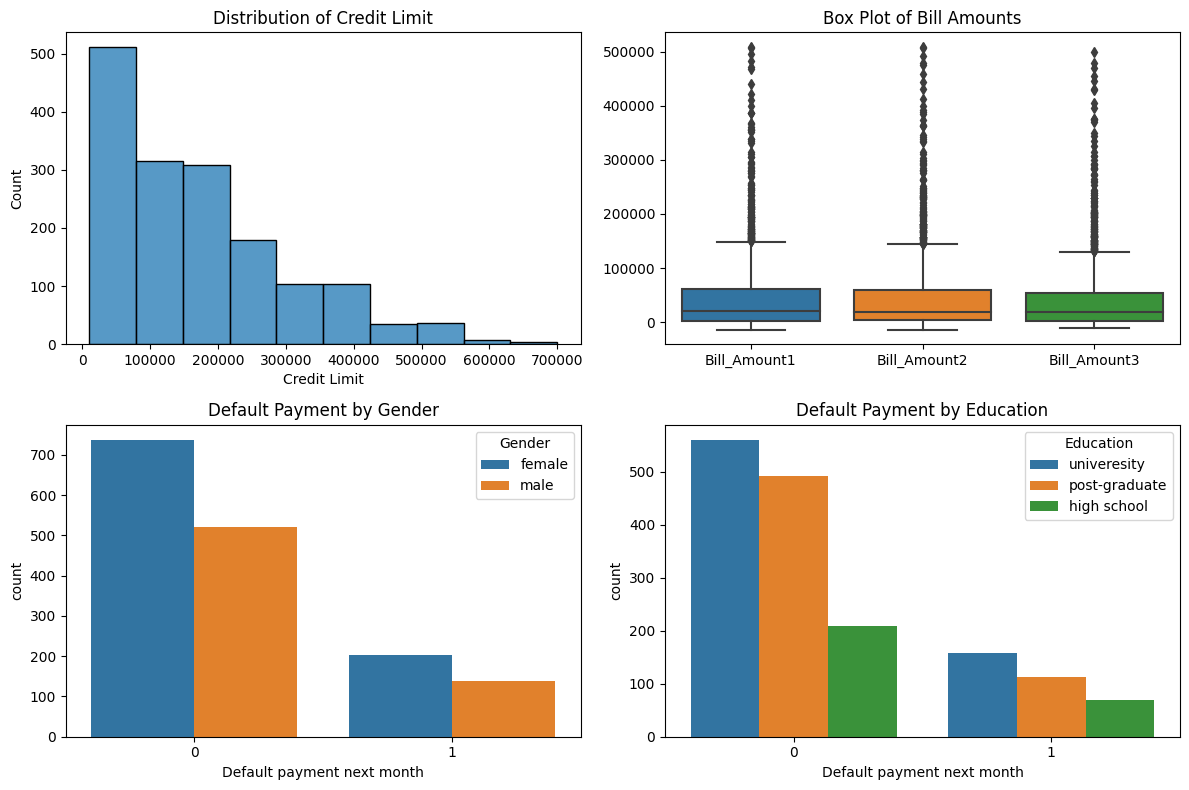

In [18]:
# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Distribution of credit limit
sns.histplot(data=paymentDF_1, x='Credit Limit', bins=10, ax=axs[0, 0])
axs[0, 0].set_title('Distribution of Credit Limit')

# Box plot of bill amounts
sns.boxplot(data=paymentDF_1[['Bill_Amount1', 'Bill_Amount2', 'Bill_Amount3']], ax=axs[0, 1])
axs[0, 1].set_title('Box Plot of Bill Amounts')

# Count plot of default payment status by gender
sns.countplot(data=paymentDF_1, x='Default payment next month', hue='Gender', ax=axs[1, 0])
axs[1, 0].set_title('Default Payment by Gender')

# Count plot of default payment status by education
sns.countplot(data=paymentDF_1, x='Default payment next month', hue='Education', ax=axs[1, 1])
axs[1, 1].set_title('Default Payment by Education')

# Show the plots
plt.tight_layout()
plt.show()

C:\Users\jatat\AppData\Local\Temp\ipykernel_9696\3715045710.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(paymentDF_1['Default payment next month'])


<AxesSubplot:xlabel='Default payment next month', ylabel='Density'>

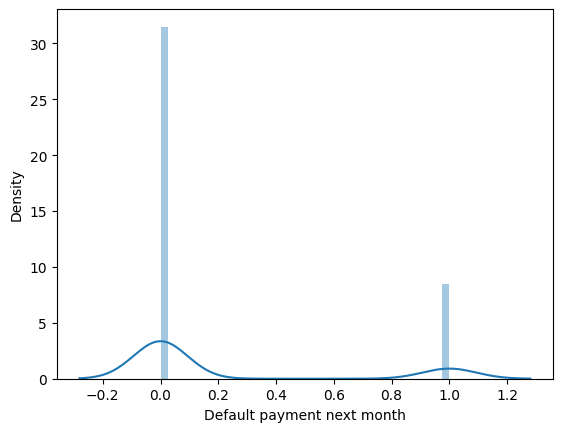

In [19]:
sns.distplot(paymentDF_1['Default payment next month'])


<h2 align="center">Imbalanced Class:</h2><br>
<body>The data is imbalanced, there are alot of 0's as compared to 1's in the 'Default payment next month' column. Synthetic Minority Oversampling Technique(SMOTE) is an oversampling technique that addresses class imbalance in a dataset.By increasing the number of minority class samples through SMOTE, the dataset becomes more balanced, which can lead to better model training and performance.</body>

<h2 align="center">Data Pre-processing(Altering the Dataset):</h2><br>

In [20]:
#Drop unnecessary feature
paymentDF_1 = paymentDF_1.drop('Customer ID', axis=1)
paymentDF_1.head(3)

,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month
0,20000,female,univeresity,married,24,3913,3102,689,0,689,0,1
1,120000,female,univeresity,single,26,2682,1725,2682,0,1000,1000,1
2,90000,female,univeresity,single,34,29239,14027,13559,1518,1500,1000,0


In [21]:
#Change categorical data to ordinal encoding

#Transform data for Gender
encoder = OrdinalEncoder(categories=[['male','female']])
reshaped_quality = paymentDF_1['Gender'].values.reshape(-1,1)
paymentDF_1['Gender'] = encoder.fit_transform(reshaped_quality)

#transform data for Marriage Status
encoder = OrdinalEncoder(categories=[['single','married']])
reshaped_quality = paymentDF_1['Marriage Status'].values.reshape(-1,1)
paymentDF_1['Marriage Status'] = encoder.fit_transform(reshaped_quality)

paymentDF_1.head(3)

,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month
0,20000,1.0,univeresity,1.0,24,3913,3102,689,0,689,0,1
1,120000,1.0,univeresity,0.0,26,2682,1725,2682,0,1000,1000,1
2,90000,1.0,univeresity,0.0,34,29239,14027,13559,1518,1500,1000,0


In [22]:
#transform data for Education
education_dummies = pd.get_dummies(paymentDF_1["Education"])
paymentDF_1 = pd.concat([paymentDF_1, education_dummies], axis=1)
paymentDF_1 = paymentDF_1.drop("Education", axis=1)

#Reorder columns high school, post-graduate,university
paymentDF_1 = paymentDF_1.iloc[:, [0, 1, 11, 12, 13, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
paymentDF_1.head(3)

,Credit Limit,Gender,high school,post-graduate,univeresity,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month
0,20000,1.0,False,False,True,1.0,24,3913,3102,689,0,689,0,1
1,120000,1.0,False,False,True,0.0,26,2682,1725,2682,0,1000,1000,1
2,90000,1.0,False,False,True,0.0,34,29239,14027,13559,1518,1500,1000,0


<h2 align="center">Data Pre-processing(Changing datatype):</h2><br>

In [23]:
# loop through every column to convert into integer data type
for column in paymentDF_1.columns:
    try:
        # attempt to convert the column to an integer type
        paymentDF_1[column] = paymentDF_1[column].astype(int)
    except ValueError:
        # if there's an error, print a message and move on to the next column
        print(f"Unable to convert column '{column}' to integer type")
        continue

<h2 align="center">Data Inspection:</h2><br>

In [24]:
# Data inspection
print("\nBasic info of dataset:\n")
paymentDF_1.info()

print("\nShape of dataset:")
paymentDF_1.shape


Basic info of dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   Credit Limit                1600 non-null   int32
 1   Gender                      1600 non-null   int32
 2   high school                 1600 non-null   int32
 3   post-graduate               1600 non-null   int32
 4   univeresity                 1600 non-null   int32
 5   Marriage Status             1600 non-null   int32
 6   Age                         1600 non-null   int32
 7   Bill_Amount1                1600 non-null   int32
 8   Bill_Amount2                1600 non-null   int32
 9   Bill_Amount3                1600 non-null   int32
 10  Pay_Amount1                 1600 non-null   int32
 11  Pay_Amount2                 1600 non-null   int32
 12  Pay_Amount3                 1600 non-null   int32
 13  Default payment next month  1600 non-n

(1600, 14)

In [25]:
paymentDF_1.head(5)

,Credit Limit,Gender,high school,post-graduate,univeresity,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month
0,20000,1,0,0,1,1,24,3913,3102,689,0,689,0,1
1,120000,1,0,0,1,0,26,2682,1725,2682,0,1000,1000,1
2,90000,1,0,0,1,0,34,29239,14027,13559,1518,1500,1000,0
3,50000,1,0,0,1,1,37,46990,48233,49291,2000,2019,1200,0
4,50000,0,0,0,1,1,57,8617,5670,35835,2000,36681,10000,0


<h2 align="center">Splitting Data</h2><br>

In [26]:
# Separate features and target variable
X = paymentDF_1.drop(columns=['Default payment next month'])
y = paymentDF_1['Default payment next month']

# Split data into train asnd test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data only
smote = SMOTE(random_state=42, sampling_strategy="minority")
X_train, y_train = smote.fit_resample(X_train, y_train)

# Apply undersampling to the resampled data
undersampler = RandomUnderSampler(random_state=42)
X_train, y_train = undersampler.fit_resample(X_train, y_train)

<h2 align="center">Performance Evaluation</h2><br>

-> <b>Precision:</b> Precision measures the reliablity of the model's positive predictions are.<br> Higher value indicates that the model has fewer false positives and is better at correctly identifying positive instances.

-> <b>Recall:</b> Precision measures the proportion of correctly predicted positive instances out of all actual positive instances<br> Higher value  indicates that the model has fewer false negatives and is better at identifying all positive instances.

-> <b>Accuracy:</b> Accuracy is the overall correctness of the model's predictions.<br> Higher value indicates better overall correctness of the model's predictions.

-> <b>F1 Score:</b> The F1 score is the harmonic mean of precision and recall.<br> Higher value indicates better balance between precision and recall.

In [27]:
# List of classifiers with their names and instances
clfs=[ ('CART',DecisionTreeClassifier()),
       ('SVR',SVC()),
      ('KNN',KNeighborsClassifier()),
      ('NB',GaussianNB()),
      ('LR',LogisticRegression()),
      ('RFC',RandomForestClassifier())  
     ]

#empty lists
pipelines = []
y_preds = []
roc_auc_scores = []

scores_df = pd.DataFrame(columns=['Model','F1_Score', 'Precision', 'Recall', 'Accuracy'])

# Iterate over each classifier in clfs
for clf_name,clf in clfs:
    pipeline=Pipeline(steps=[
    ('scaler',StandardScaler()),
    ('classifier',clf)])
    
    #Fit, predict and append
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    pipelines.append(pipeline)
    
    #for confusion matrix
    y_preds.append(y_pred)
    
    #calculate performance scores
    new_row = {'Model' : clf_name, \
          'F1_Score' : metrics.f1_score(y_test,y_pred,average='binary'),
          'Precision' : metrics.precision_score(y_test, y_pred, average='binary', zero_division=1),
          'Recall' : metrics.recall_score(y_test, y_pred, average='binary'),
          'Accuracy' : metrics.accuracy_score(y_test, y_pred)}
    
    # Concatenate new row to scores_df
    scores_df = pd.concat([scores_df,pd.DataFrame([new_row])], ignore_index=True)
    
print(scores_df)


  Model  F1_Score  Precision    Recall  Accuracy
0  CART  0.264151   0.256098  0.272727  0.634375
1   SVR  0.123894   0.194444  0.090909  0.690625
2   KNN  0.257143   0.285714  0.233766  0.675000
3    NB  0.382716   0.251012  0.805195  0.375000
4    LR  0.155340   0.307692  0.103896  0.728125
5   RFC  0.236364   0.393939  0.168831  0.737500


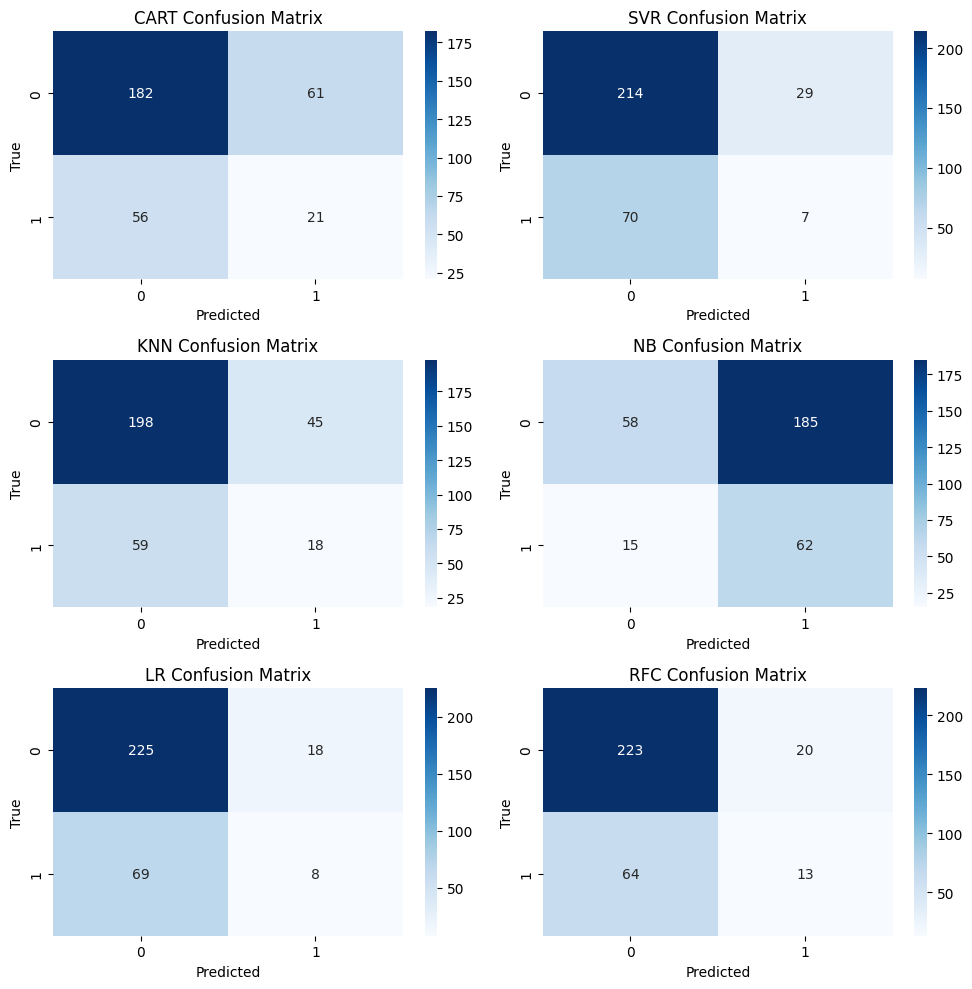

In [28]:
# Calculate number of rows and columns needed for subplot grid
n_models = len(clfs)
n_cols = min(2, n_models)
n_rows = ceil(n_models / n_cols)

# Create figure and subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))

# Loop through predictions and calculate confusion matrix
for i, y_pred in enumerate(y_preds):
    cm = metrics.confusion_matrix(y_test, y_pred)

    # Calculate row and column index for subplot
    row_idx = i // n_cols
    col_idx = i % n_cols

    # Display confusion matrix with labels
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(clfs[i][0] + ' Confusion Matrix')
    axes[row_idx, col_idx].set_xlabel('Predicted')
    axes[row_idx, col_idx].set_ylabel('True')
    
#     Hide empty subplots,if have
for i in range(len(clfs), n_rows * n_cols):
    row_idx = i // n_cols
    col_idx = i % n_cols
    axes[row_idx, col_idx].axis('off')

#display plot
plt.tight_layout()
plt.show()

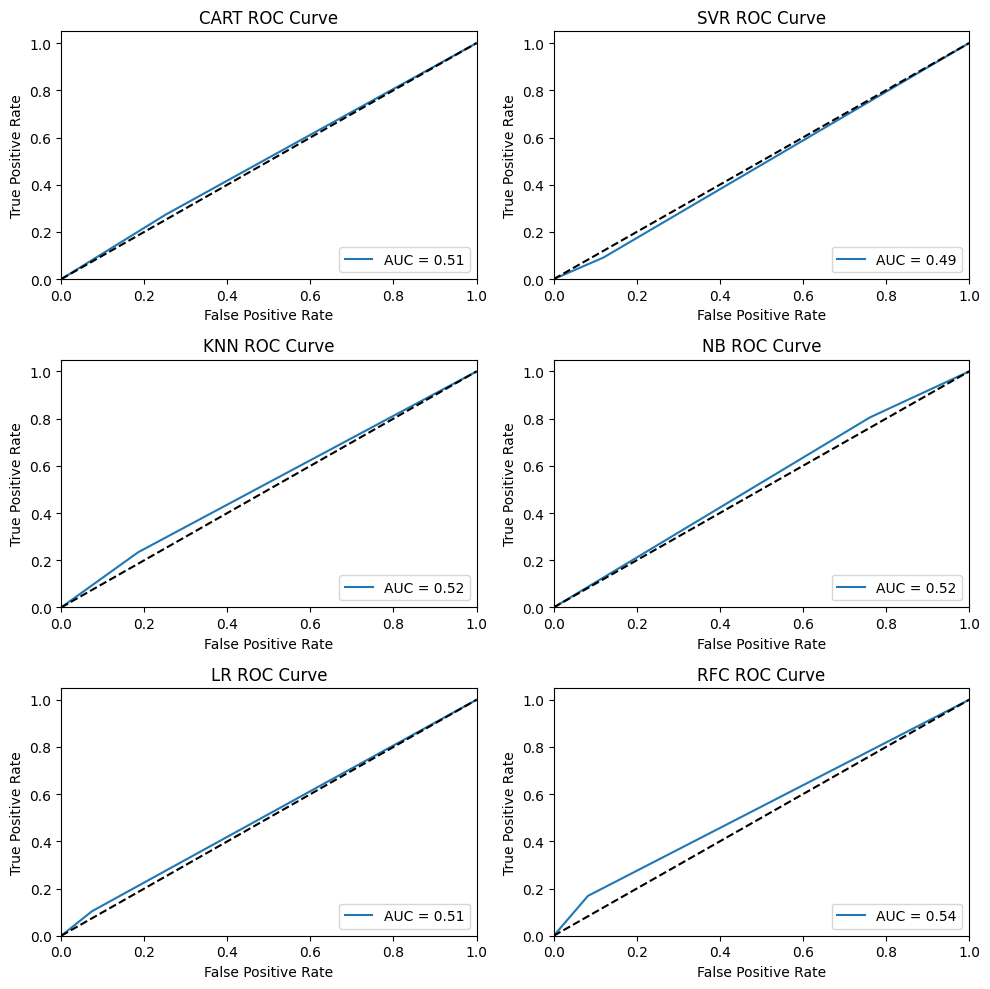

In [29]:
# Create figure and subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))

# Loop through predictions and calculate ROC curve
for i, y_pred in enumerate(y_preds):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Calculate row and column index for subplot
    row_idx = i // n_cols
    col_idx = i % n_cols

    # Plot ROC curve
    axes[row_idx, col_idx].plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc))
    axes[row_idx, col_idx].plot([0, 1], [0, 1], 'k--')
    axes[row_idx, col_idx].set_xlim([0.0, 1.0])
    axes[row_idx, col_idx].set_ylim([0.0, 1.05])
    axes[row_idx, col_idx].set_xlabel('False Positive Rate')
    axes[row_idx, col_idx].set_ylabel('True Positive Rate')
    axes[row_idx, col_idx].set_title(clfs[i][0] + ' ROC Curve')
    axes[row_idx, col_idx].legend(loc='lower right')

# Hide empty subplots
for i in range(len(clfs), n_rows * n_cols):
    row_idx = i // n_cols
    col_idx = i % n_cols
    axes[row_idx, col_idx].axis('off')

# Display the plot
plt.tight_layout()
plt.show()


<h2 align="center">Why i chose Random Forest Classifier</h2><br>
<b>High-Dimensional Data:</b> RFC can handle high-dimensional data effectively. With multiple features such as "Credit Limit", "Gender", "Education Level", etc. RFC can handle the complexity and interactions among these variables.

<b>Handling Imbalanced Classes:</b> RFC can handle imbalanced classes situations well. RFC can address class imbalance and prevent biased predictions towards the majority class.


<b>Nonlinear Relationships:</b> RFC can capture nonlinear relationships between features and the target variable. In this dataset, there may exist complex interactions between variables, such as the relationship between "Age" and "Default payment next month," or the combined effect of "Bill_Amount" and "Pay_Amount" variables.

<b>Metric scores:</b> RFC is the generally best performing model out of all the models tested based on metrics scores.<br>(example):<br><br>
<b>Model&nbsp;&nbsp;&nbsp;F1_Score&nbsp;&nbsp;&nbsp;Precision&nbsp;&nbsp;&nbsp;Recall&nbsp;&nbsp;&nbsp;Accuracy</b><br>
 CART&nbsp;&nbsp;&nbsp;  0.258065&nbsp;&nbsp;&nbsp;  0.256410&nbsp;&nbsp;&nbsp;  0.259740&nbsp;&nbsp;&nbsp;  0.640625<br>
 SVR&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  0.123894&nbsp;&nbsp;&nbsp;  0.194444&nbsp;&nbsp;&nbsp;  0.090909&nbsp;&nbsp;&nbsp;  0.690625<br>
 KNN&nbsp;&nbsp;&nbsp;&nbsp;  0.257143&nbsp;&nbsp;&nbsp;  0.285714&nbsp;&nbsp;&nbsp;  0.233766&nbsp;&nbsp;&nbsp;  0.675000<br>
 NB&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  0.382716&nbsp;&nbsp;&nbsp;  0.251012&nbsp;&nbsp;&nbsp;  0.805195&nbsp;&nbsp;&nbsp;  0.375000<br>
 LR&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  0.155340&nbsp;&nbsp;&nbsp;  0.307692&nbsp;&nbsp;&nbsp;  0.103896&nbsp;&nbsp;&nbsp;  0.728125<br>
 <u>RFC</u>&nbsp;&nbsp;&nbsp;  0.243478&nbsp;&nbsp;&nbsp;  0.368421&nbsp;&nbsp;&nbsp;  0.181818&nbsp;&nbsp;&nbsp;  0.728125
 
<b>ROC curve:</b> On the ROC curve, all the models perform roughly the same, so it does not matter<br><br>

<h2 align="center">Hyperparameter tuning</h2><br>

In [30]:
RFC = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
])

param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
}


# Create a KFold object for cross-validation
kf1=KFold(n_splits=10,shuffle = True,random_state=42)

# Instantiate model
RFC1 = RandomForestClassifier()

# Instantiate CV
RFC_cv = GridSearchCV(RFC1, param_grid, cv=kf1, n_jobs=-1)

# Fit to the training data
RFC_cv.fit(X_train,y_train)

print("Tuned RFC paramaters: {}".format(RFC_cv.best_params_))
print("Tuned RFC score: {}".format(RFC_cv.best_score_))

Tuned RFC paramaters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Tuned RFC score: 0.8525258379213755


In [31]:
from sklearn.metrics import average_precision_score

# Get the best model from the grid search
best_RFC = RFC_cv.best_estimator_

# Predict probabilities on the test set
y_pred_proba = best_RFC.predict_proba(X_test)[:, 1]  # Assuming binary classification

# Calculate average precision
average_precision = average_precision_score(y_test, y_pred_proba)

# Print the average precision
print("Average Precision: {}".format(average_precision))

Average Precision: 0.290868523272539


In [32]:
# Predict on the test data
y_pred1 = RFC_cv.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred1))


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.90      0.83       243
           1       0.36      0.18      0.24        77

    accuracy                           0.73       320
   macro avg       0.57      0.54      0.54       320
weighted avg       0.68      0.72      0.69       320



In [33]:
#metrics calculation
accuracy = accuracy_score(y_test, y_pred1)
precision = precision_score(y_test, y_pred1)
recall = recall_score(y_test, y_pred1)
f1 = f1_score(y_test, y_pred1)

#print metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))

Accuracy: 0.7250
Precision: 0.3590
Recall: 0.1818
F1-score: 0.2414


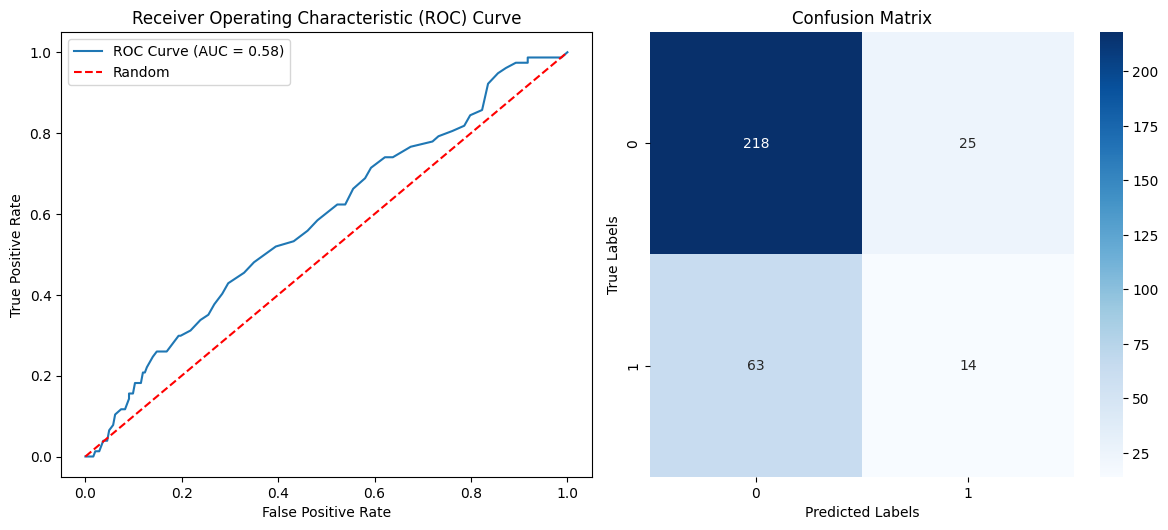

In [34]:
# Make predictions on the test data using the best model
y_pred1 = RFC_cv.predict(X_test)

# Calculate the probabilities for the positive class
y_pred_proba = RFC_cv.predict_proba(X_test)[:, 1]

# ROC Curve calculation
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

# Confusion Matrix calculation
cm = confusion_matrix(y_test, y_pred1)

# Plotting in a 2x2 subplot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# ROC Curve plot
axes[0, 0].plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
axes[0, 0].plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[0, 0].legend()

# Confusion Matrix plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_xlabel('Predicted Labels')
axes[0, 1].set_ylabel('True Labels')
axes[0, 1].set_title('Confusion Matrix')

# Remove the bottom two subplots
fig.delaxes(axes[1, 0])
fig.delaxes(axes[1, 1])
plt.tight_layout()
plt.show()


<h2 align="center">Hyperparameter tuning summary</h2><br>
After hyperparameter tuning and cross validation, we can see that the RFC model has improved in performance and is better in predicting default payment now.

<h1 align="center">PART B: Regression</h1><br>
<center><u><h2><b>Objective: Develop a regression model to predict property prices</b></h2></u><br><br></center>
<b>House ID:</b> A unique identifier for each house.<br><br>
<b>City:</b> The city where the house is located.<br><br>
<b>House Area (sqm):</b> The total area of the house in square meters.<br><br>
<b>No. of Bedrooms:</b> The number of bedrooms in the house.<br><br>
<b>No. of Toilets:</b> The number of toilets/bathrooms in the house.<br><br>
<b>Stories:</b> The number of stories/floors in the house.<br><br>
<b>Renovation Status:</b> The renovation status of the house, indicating whether it is furnished, semi-furnished, or not furnished.<br><br>
<b>Price ($):</b> The price of the house in dollars.<br><br>




<h2 align="center">Importing libraries & dataset:</h2><br>

In [35]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [36]:
#load dataset
housingDF = pd.read_csv('housing_dataset.csv')
housingDF.head(5)

,House ID,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($)
0,0,Chicago,742.0,4,2,3,furnished,1330000
1,1,Denver,896.0,4,4,4,furnished,1225000
2,2,Chicago,996.0,3,2,2,semi-furnished,1225000
3,3,Seattle,750.0,4,2,2,furnished,1221500
4,4,New York,742.0,4,1,2,furnished,1141000


<h2 align="center">Data Pre-processing(Handling Missing Data,If any):</h2><br>

In [37]:
# Check for missing values
print(f"{housingDF.isnull().sum()}\n")

House ID             0
City                 0
House Area (sqm)     0
No. of Bedrooms      0
No. of Toilets       0
Stories              0
Renovation Status    0
Price ($)            0
dtype: int64



In [38]:
#impute missing data using 'most_frequent', cannot use other ways due to non numeric data
imputer = SimpleImputer(strategy='most_frequent')

# Fit the imputer on the dataset
imputer.fit(housingDF)

# Transform the dataset to impute missing values
housingDF_1 = imputer.transform(housingDF)
housingDF_1 = pd.DataFrame(housingDF_1, columns=housingDF.columns)

# print imputed data
housingDF_1.head(5)


,House ID,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($)
0,0,Chicago,742.0,4,2,3,furnished,1330000
1,1,Denver,896.0,4,4,4,furnished,1225000
2,2,Chicago,996.0,3,2,2,semi-furnished,1225000
3,3,Seattle,750.0,4,2,2,furnished,1221500
4,4,New York,742.0,4,1,2,furnished,1141000


<h2 align="center">Data visualisations</h2><br>

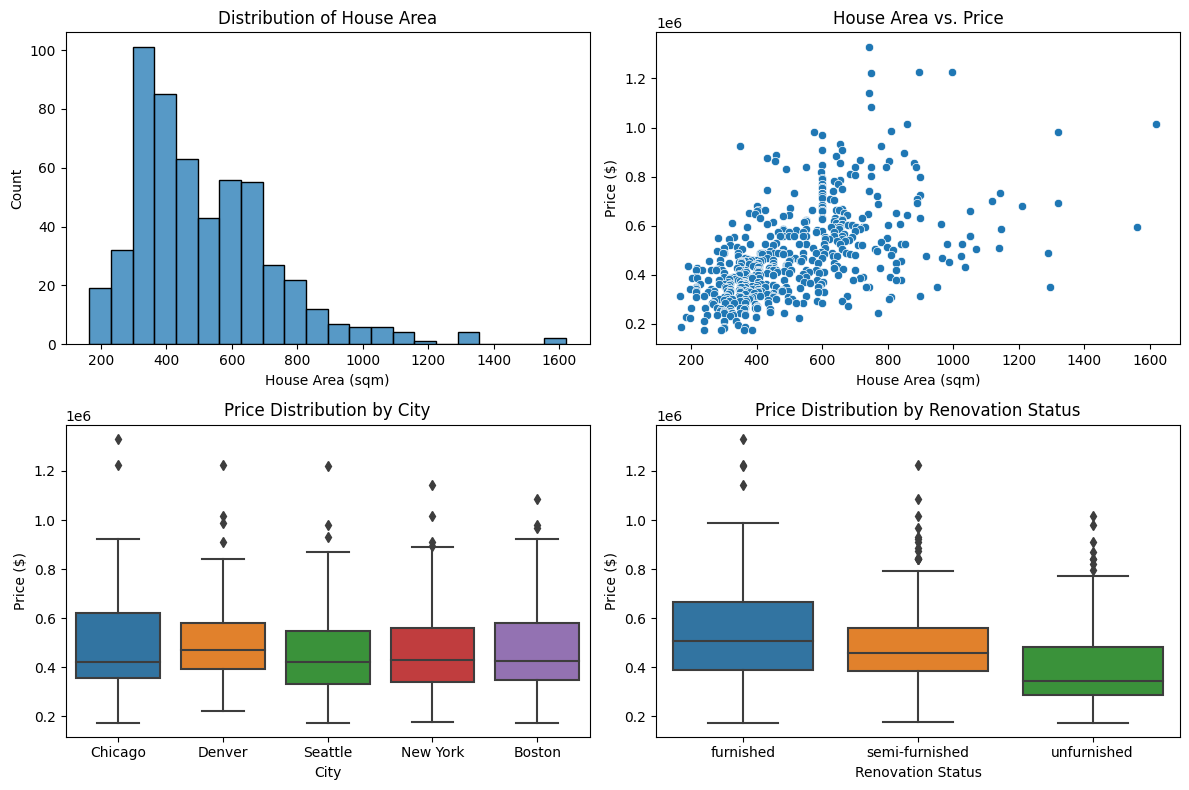

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 2x2 subplot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot the distribution of house area
sns.histplot(housingDF_1['House Area (sqm)'], ax=axes[0, 0])
axes[0, 0].set_xlabel('House Area (sqm)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Distribution of House Area')

# Plot the relationship between house area and price
sns.scatterplot(x='House Area (sqm)', y='Price ($)', data=housingDF_1, ax=axes[0, 1])
axes[0, 1].set_xlabel('House Area (sqm)')
axes[0, 1].set_ylabel('Price ($)')
axes[0, 1].set_title('House Area vs. Price')

# Plot the relationship between price and location
sns.boxplot(x='City', y='Price ($)', data=housingDF_1, ax=axes[1, 0])
axes[1, 0].set_xlabel('City')
axes[1, 0].set_ylabel('Price ($)')
axes[1, 0].set_title('Price Distribution by City')

# Plot the relationship between price and status
sns.boxplot(x='Renovation Status', y='Price ($)', data=housingDF_1, ax=axes[1, 1])
axes[1, 1].set_xlabel('Renovation Status')
axes[1, 1].set_ylabel('Price ($)')
axes[1, 1].set_title('Price Distribution by Renovation Status')

# Adjust the layout and spacing between the subplots
fig.tight_layout()

# Show the plot
plt.show()


<h2 align="center">Data Pre-processing(Altering the Dataset):</h2><br>

In [40]:
#Drop unnecessary feature
housingDF_1 = housingDF_1.drop('House ID', axis=1)
housingDF_1.head(3)

,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($)
0,Chicago,742.0,4,2,3,furnished,1330000
1,Denver,896.0,4,4,4,furnished,1225000
2,Chicago,996.0,3,2,2,semi-furnished,1225000


In [41]:
# Convert categorical variables into numerical using one-hot encoding
housingDF_1 = pd.get_dummies(housingDF_1, columns=['City', 'Renovation Status'])
housingDF_1.head(3)

,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Price ($),City_Boston,City_Chicago,City_Denver,City_New York,City_Seattle,Renovation Status_furnished,Renovation Status_semi-furnished,Renovation Status_unfurnished
0,742.0,4,2,3,1330000,False,True,False,False,False,True,False,False
1,896.0,4,4,4,1225000,False,False,True,False,False,True,False,False
2,996.0,3,2,2,1225000,False,True,False,False,False,False,True,False


<h2 align="center">Data Pre-processing(Changing datatype):</h2><br>

In [42]:
# loop through every column to convert into integer data type
for column in housingDF_1.columns:
    try:
        # attempt to convert the column to an integer type
        housingDF_1[column] = housingDF_1[column].astype(int)
    except ValueError:
        # if there's an error, print a message and move on to the next column
        print(f"Unable to convert column '{column}' to integer type")
        continue

<h2 align="center">Data Inspection:</h2><br>

In [43]:
# Data inspection
print("\nBasic info of dataset:\n")
housingDF_1.info()

print("\nShape of dataset:")
housingDF_1.shape


Basic info of dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   House Area (sqm)                  545 non-null    int32
 1   No. of Bedrooms                   545 non-null    int32
 2   No. of Toilets                    545 non-null    int32
 3   Stories                           545 non-null    int32
 4   Price ($)                         545 non-null    int32
 5   City_Boston                       545 non-null    int32
 6   City_Chicago                      545 non-null    int32
 7   City_Denver                       545 non-null    int32
 8   City_New York                     545 non-null    int32
 9   City_Seattle                      545 non-null    int32
 10  Renovation Status_furnished       545 non-null    int32
 11  Renovation Status_semi-furnished  545 non-null    int32
 12  Renovation 

(545, 13)

In [44]:
housingDF_1.head(5)

,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Price ($),City_Boston,City_Chicago,City_Denver,City_New York,City_Seattle,Renovation Status_furnished,Renovation Status_semi-furnished,Renovation Status_unfurnished
0,742,4,2,3,1330000,0,1,0,0,0,1,0,0
1,896,4,4,4,1225000,0,0,1,0,0,1,0,0
2,996,3,2,2,1225000,0,1,0,0,0,0,1,0
3,750,4,2,2,1221500,0,0,0,0,1,1,0,0
4,742,4,1,2,1141000,0,0,0,1,0,1,0,0


<h2 align="center">Splitting Data</h2><br>

In [45]:
# Separate the features (X) and the target variable (y)
X = housingDF_1.drop('Price ($)', axis=1)
y = housingDF_1['Price ($)']

# Split data into train asnd test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h2 align="center">Calculating & Interpreting Performance(Regression)</h2><br>

-> <b>Mean Squared Error:</b> MSE measures average squared difference between predicted and actual values. .<br> A lower value indicates better performance.

-> <b>Root Mean Squared Error:</b> RMSE provides interpretable measure of average prediction error in the original units of target variable.<br>A lower value indicates better performance.

-> <b>Mean Absolute Error:</b> MAE measures the average magnitude of the errors made by the model.<br>A lower value indicates better performance.

-> <b>Mean Absolute Percentage Error:</b> MAPE calculates average percentage difference between the predicted and actual values.<br>A lower value indicates better performance.

-> <b>Coefficient of Determination:</b> R2 represents Proportion of variance in target variable explained by the model.<br>A Higher value indicates better performance.

In [46]:
clfs=[('LR',LinearRegression()),
      ('CART',DecisionTreeRegressor()),
       ('SVR',SVR()),
      ('Ridge',Ridge()),
      ('Lasso',Lasso()),
      ('RFR',RandomForestRegressor()),
     ]

pipeline=[]
pipelines=[]

scores_df=pd.DataFrame(columns=['model','MSE','RMSE','MAE','MAPE','R2'])

for clf_name,clf in clfs:
    pipeline=Pipeline(steps=[
        #data transformation
    ('scaler',StandardScaler()),
    ('classifier',clf)])
    
    pipeline.fit(X_train,y_train)
    y_pred=pipeline.predict(X_test)
    pipelines.append(pipeline)

    new_row={'model' : clf_name,\
            'MSE' : mean_squared_error(y_test, y_pred),
            'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
            'MAE' : mean_absolute_error(y_test, y_pred),
            'MAPE' : mean_absolute_percentage_error(y_test, y_pred),
            'R2' : r2_score(y_test, y_pred)}

    scores_df=pd.concat([scores_df,pd.DataFrame([new_row])],ignore_index=True)

print(scores_df)

   model           MSE           RMSE            MAE      MAPE        R2
0     LR  2.414027e+10  155371.405700  117288.559293  0.258517  0.522407
1   CART  4.067861e+10  201689.386720  137431.192661  0.285709  0.195211
2    SVR  5.567672e+10  235959.138549  176383.086098  0.367112 -0.101512
3  Ridge  2.415055e+10  155404.470196  117284.939488  0.258540  0.522204
4  Lasso  2.414028e+10  155371.417290  117288.227547  0.258516  0.522407
5    RFR  2.658183e+10  163039.339318  117294.028410  0.254836  0.474103


C:\Users\jatat\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.257e+10, tolerance: 1.344e+09
  model = cd_fast.enet_coordinate_descent(


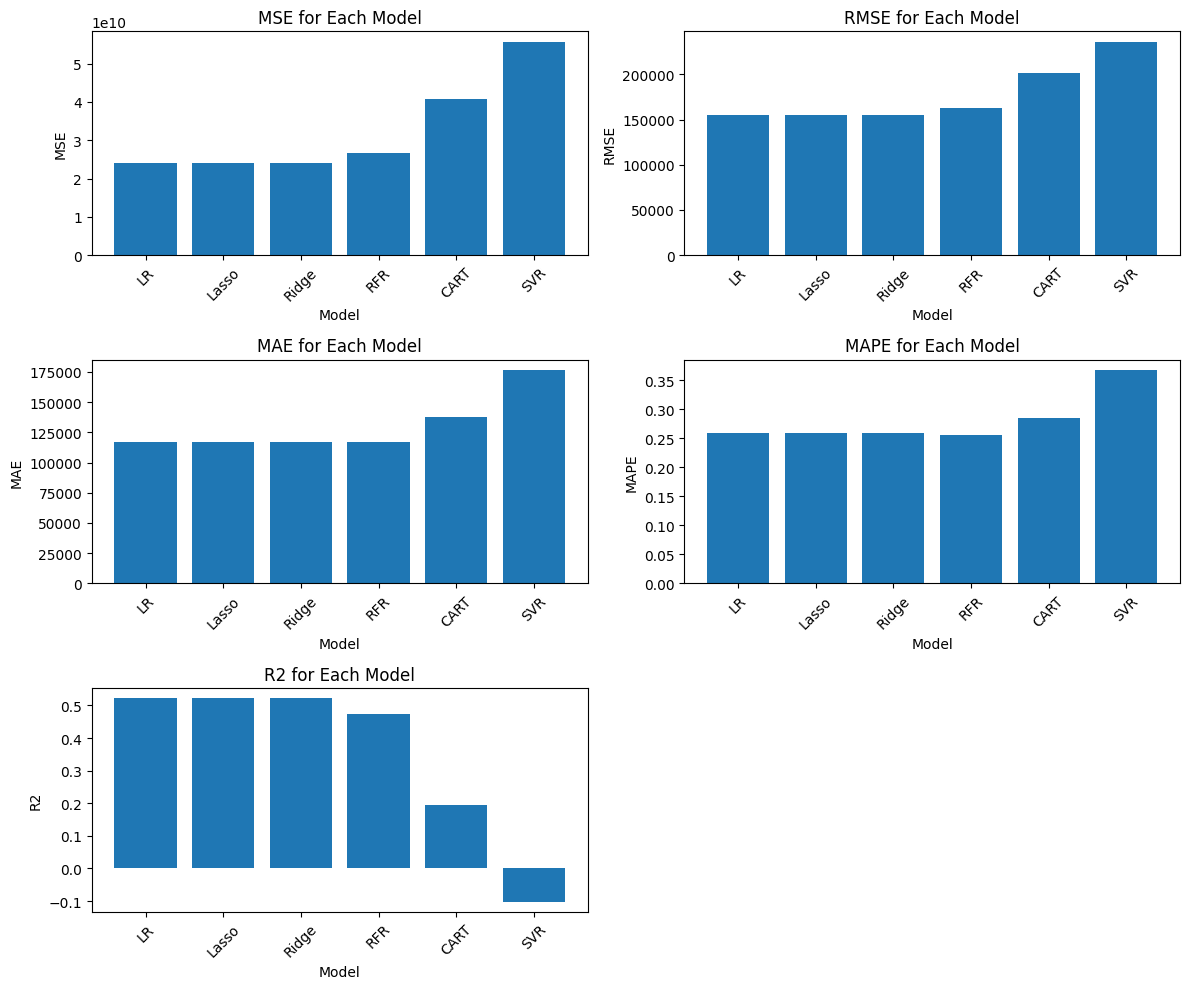

In [47]:
# Sort the DataFrame by metric values in ascending order
metrics = ['MSE', 'RMSE', 'MAE', 'MAPE', 'R2']
scores_df_sorted = scores_df.sort_values(by=metrics)

# Set the figure size and layout
plt.figure(figsize=(12, 10))
plt.subplots_adjust(hspace=0.4)

# Iterate over the metrics and create subplots
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    plt.bar(scores_df_sorted['model'], scores_df_sorted[metric])
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.title(f'{metric} for Each Model')
    plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


<h2 align="center">Why i chose Linear Regression</h2><br>
<b>Interpretability:</b> Interpretable coefficients can be obtained by linear regression, which show the strength and direction of the correlation between each independent variable and the target variable. This helps in understanding the factors that influence the house price.

<b>Simplicity:</b> Linear regression is a simple and straightforward model compared to more complex models such as neural networks. It is easy to implement and understand.

<b>Metric scores:</b> Linear regression is the generally best performing model out of all the models tested based on metrics scores.<br>(example):<br><br>
model&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  MSE&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  RMSE&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  MAE&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  MAPE&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  R2<br>

LR&nbsp;&nbsp;&nbsp;  2.405954e+10&nbsp;&nbsp;&nbsp;  155111.375787&nbsp;&nbsp;&nbsp;  116853.671712&nbsp;&nbsp;&nbsp;  0.257733&nbsp;&nbsp;&nbsp;  0.524004<br>
CART&nbsp;&nbsp;&nbsp;  4.085541e+10&nbsp;&nbsp;&nbsp;  202127.220588&nbsp;&nbsp;&nbsp;  138394.495413&nbsp;&nbsp;&nbsp;  0.286595&nbsp;&nbsp;&nbsp;  0.191713<br>
SVR&nbsp;&nbsp;&nbsp;  5.567672e+10&nbsp;&nbsp;&nbsp;  235959.138549&nbsp;&nbsp;&nbsp;  176383.086098&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  0.367112&nbsp;&nbsp;&nbsp; -0.101512<br>
Ridge&nbsp;&nbsp;&nbsp;  2.415055e+10&nbsp;&nbsp;&nbsp;  155404.470196&nbsp;&nbsp;&nbsp;  117284.939488&nbsp;&nbsp;&nbsp;  0.258540&nbsp;&nbsp;&nbsp;  0.522204<br>
Lasso&nbsp;&nbsp;&nbsp;  2.414028e+10&nbsp;&nbsp;&nbsp;  155371.417290&nbsp;&nbsp;&nbsp;  117288.227547&nbsp;&nbsp;&nbsp;  0.258516&nbsp;&nbsp;&nbsp;  0.522407<br>
RFR&nbsp;&nbsp;&nbsp;  2.755999e+10&nbsp;&nbsp;&nbsp;  166012.007912&nbsp;&nbsp;&nbsp;  117905.007258&nbsp;&nbsp;&nbsp;  0.254718&nbsp;&nbsp;&nbsp;  0.454751<br>

<h2 align="center">Hyperparameter tuning</h2><br>

In [48]:
RFC = Pipeline([
    ('scaler', StandardScaler()),
    ('LR', LinearRegression())
])

param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False]
}

# Create the linear regression model
LR_cv = LinearRegression()

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=LR_cv, param_grid=param_grid, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Create a KFold object for cross-validation
kf1=KFold(n_splits=10,shuffle = True,random_state=42)

# Instantiate CV
LR_cv = GridSearchCV(LR_cv, param_grid, cv=kf1)

# Fit the best model on the training data
LR_cv.fit(X_train, y_train)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)

print("Tuned RFC paramaters: {}".format(RFC_cv.best_params_))
print("Tuned RFC score: {}".format(RFC_cv.best_score_))

Tuned RFC paramaters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Tuned RFC score: 0.8525258379213755


In [49]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 24140273709.130802
Mean Absolute Error (MAE): 117288.5592927204
R-squared (R2) Score: 0.5224069993583242
